In [1]:
%matplotlib inline
import os
import warnings
import numpy as np
import pandas as pd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
import seaborn as sn
import toc_trends_analysis as toc_trends
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from IPython.display import Image

warnings.simplefilter(action='ignore', category=FutureWarning)
pandas2ri.activate()
plt.style.use('ggplot')
bcp = importr('bcp')

# TOC Thematic Report - February 2019 (part 5: changepoint detection)

We have previously discussed implementing change-point detection for the ICPW water chemistry time series. Depending on the amount of data available, there are two broad approaches to this problem:

 1. Fit an explicit time series model capable of representing trends and seasonalities (and including break-point detection for the trend component), or  
 
 2. Fit a piecewise linear model to aggregated annual data (where the aggregation serves as a coarse way of removing seasonalities)
 
The first approach has the potential to be more informative, but also requires more data. The second method is more appropriate in situations where we don't have enough information to accurately characterise seasonalities, but believe we do have enough to estimate annual means or medians.

This notebook explores both options using a Bayesian approach.

## 1. Sites of interest

In this notebook, I'm going to focus on stations with lots of data so that I can compare results from the two approaches described above. A [previous notebook](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part3.ipynb) identified stations with *at least* 25 samples per year, *every year* from 1990 to 2016.





In [2]:
# At least 25 samples per year
hi_freq_csv = r'../../../Thematic_Trends_Report_2019/hi_freq_stns.csv'
hi_freq_df = pd.read_csv(hi_freq_csv)
hi_freq_df

station_id      station_code                                station_name  \
0       38085         Tr18_CA01     Ontario, Algoma Region, Batchawana Lake   
1       38086         Tr18_CA02        Ontario, Algoma Region, Wishart Lake   
2       38087         Tr18_CA03  Ontario, Algoma Region, Little Turkey Lake   
3       38088         Tr18_CA04         Ontario, Algoma Region, Turkey Lake   
4       38312     Tr18_NO_BIE01                                    Birkenes   
5       38316    Tr18_NO_DALELV                                      Dalelv   
6       38242     Tr18_NO_LAE01                            Langtjern, utløp   
7       38314     Tr18_NO_STE01                             Storgama v. dam   
8       38470  Tr18_US_01434025                    Biscuit Brook, Catskills   
9       23623             US104                       Piney River, Virginia   

    latitude  longitude  altitude      continent        country  region  \
0  47.060000 -84.393000     497.0  North America         Canada     Ont   
1  47.041000 -84.402000     388.0  North America         Canada     Ont   
2  47.041000 -84.406000     375.0  North America         Canada     Ont   
3  47.050000 -84.408000     372.0  North America         Canada     Ont   
4  58.385426   8.241721     190.0         Europe         Norway  SoNord   
5  69.684738  30.386154      10.0         Europe         Norway  NoNord   
6  60.372460   9.726660     516.0         Europe         Norway  SoNord   
7  59.052333   8.653606     587.0         Europe         Norway  SoNord   
8  42.011100 -74.414700     634.0  North America  United States  AdsCsk   
9  38.703000 -78.268700     360.0  North America  United States     BRM   

         group  
0  Trends+Core  
1  Trends+Core  
2  Trends+Core  
3  Trends+Core  
4  Trends+Core  
5  Trends+Core  
6  Trends+Core  
7  Trends+Core  
8  Trends+Core  
9         Core

## 2. Prophet time series model

[Prophet](https://facebook.github.io/prophet/) is 

 > an additive model where non-linear trends are fit with yearly, weekly and daily seasonalities, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
 
The algorithm was originally designed for forecasting with economic and social media datasets, but many of the design choices also seem applicable to environmental data. 

### 2.1. Read raw data

In [3]:
# Load saved data
wc_csv = r'../../../Thematic_Trends_Report_2019/working_chem.csv'
wc_df = pd.read_csv(wc_csv, encoding='utf-8')
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'])
wc_df.head()

station_id station_code  station_name sample_date  depth1  depth2  TOC  \
0       23472         CH03  Lago di Tomè  1990-10-08     0.0     0.0  NaN   
1       23472         CH03  Lago di Tomè  1993-08-18     0.0     0.0  NaN   
2       23472         CH03  Lago di Tomè  1995-09-05     0.0     0.0  NaN   
3       23472         CH03  Lago di Tomè  1995-09-15     0.0     0.0  NaN   
4       23472         CH03  Lago di Tomè  1997-08-05     0.0     0.0  NaN   

         EH      ESO4X       ENO3  ECaX_EMgX        ANC  
0  3.630781  44.499714  23.571429  63.201619  10.939799  
1  3.630781  47.620048  35.000000  46.966952 -15.749821  
2  2.630268  46.195810  36.428571  80.601524   5.850613  
3  4.073803  41.200476  32.142857  57.336190  -3.319358  
4  2.089296  37.982524  23.571429  52.235143   3.383879

### 1.2. Fit model

The code below uses **monthly median concentrations** and fits a "standard" Prophet model with linear growth and additive components (i.e. $value = trend + seasonalities$). I've turned off the daily and weekly components, as these are not relevant to the aggregated monthly datasets. I've also set `'yearly_seasonality=1'` (a low value) to "damp" oscillations in the seasonal component.

In [4]:
# Folder to save plots
out_fold = r'../../../Thematic_Trends_Report_2019/results/change_plots'

# Pars of interest
pars = ['TOC', 'EH', 'ESO4X', 'ENO3', 'ECaX_EMgX', 'ANC']

In [5]:
# Loop over stations
for stn_id in hi_freq_df['station_id'].values:
    # Get data for stn
    df = wc_df.query('station_id == @stn_id').copy()
    del df['station_id'], df['station_code'], df['station_name']
    del df['depth1'], df['depth2']
    
    df.set_index('sample_date', inplace=True)
    df = df.resample('M').median().reset_index()
    
    # Setup plots
    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,20))

    # Loop over pars
    for idx, par in enumerate(pars):
        # Get data and reformat for Prophet
        df2 = df[['sample_date', par]].copy()
        df2.columns = ['ds', 'y']

        # Fit model
        m = Prophet(growth='linear',                 # Or 'logistic'
                    seasonality_mode='additive',     # Or 'multiplicative'
                    daily_seasonality=False,
                    weekly_seasonality=False,
                    yearly_seasonality=1)            # Bigger => more flexibility in seasonality
        m.fit(df2)
    
        # Plot results (within-sample)
        fcst = m.predict(df2)
        fig = m.plot(fcst, ax=axes[idx, 0])
        a = add_changepoints_to_plot(axes[idx, 0], m, fcst)
        axes[idx, 0].set_ylabel(par)
        axes[idx, 0].set_xlabel('')
    
        # Plot trend component
        axes[idx, 1].plot(fcst['ds'], fcst['trend'])
    
        # Plot seasonal cycle    
        seas_df = m.predict(pd.DataFrame({'ds':pd.date_range(start='2016-01-01', 
                                                             periods=365)}))
        axes[idx, 2].plot(seas_df['ds'], seas_df['yearly'])
    
        # Label formatting for seasonal
        months = MonthLocator(range(1, 13), bymonthday=1, interval=2)
        axes[idx, 2].xaxis.set_major_formatter(FuncFormatter(
            lambda x, pos=None: '{dt:%b} {dt.day}'.format(dt=num2date(x))))
        axes[idx, 2].xaxis.set_major_locator(months)

        # Titles along top row
        axes[0, 0].set_title('Fitted model and change-points')
        axes[0, 1].set_title('Trend component')
        axes[0, 2].set_title('Seasonal cycle')

    plt.tight_layout()
    out_png = os.path.join(out_fold, 'prophet_stn_%s.png' % stn_id)
    plt.savefig(out_png, dpi=300)
    plt.close()

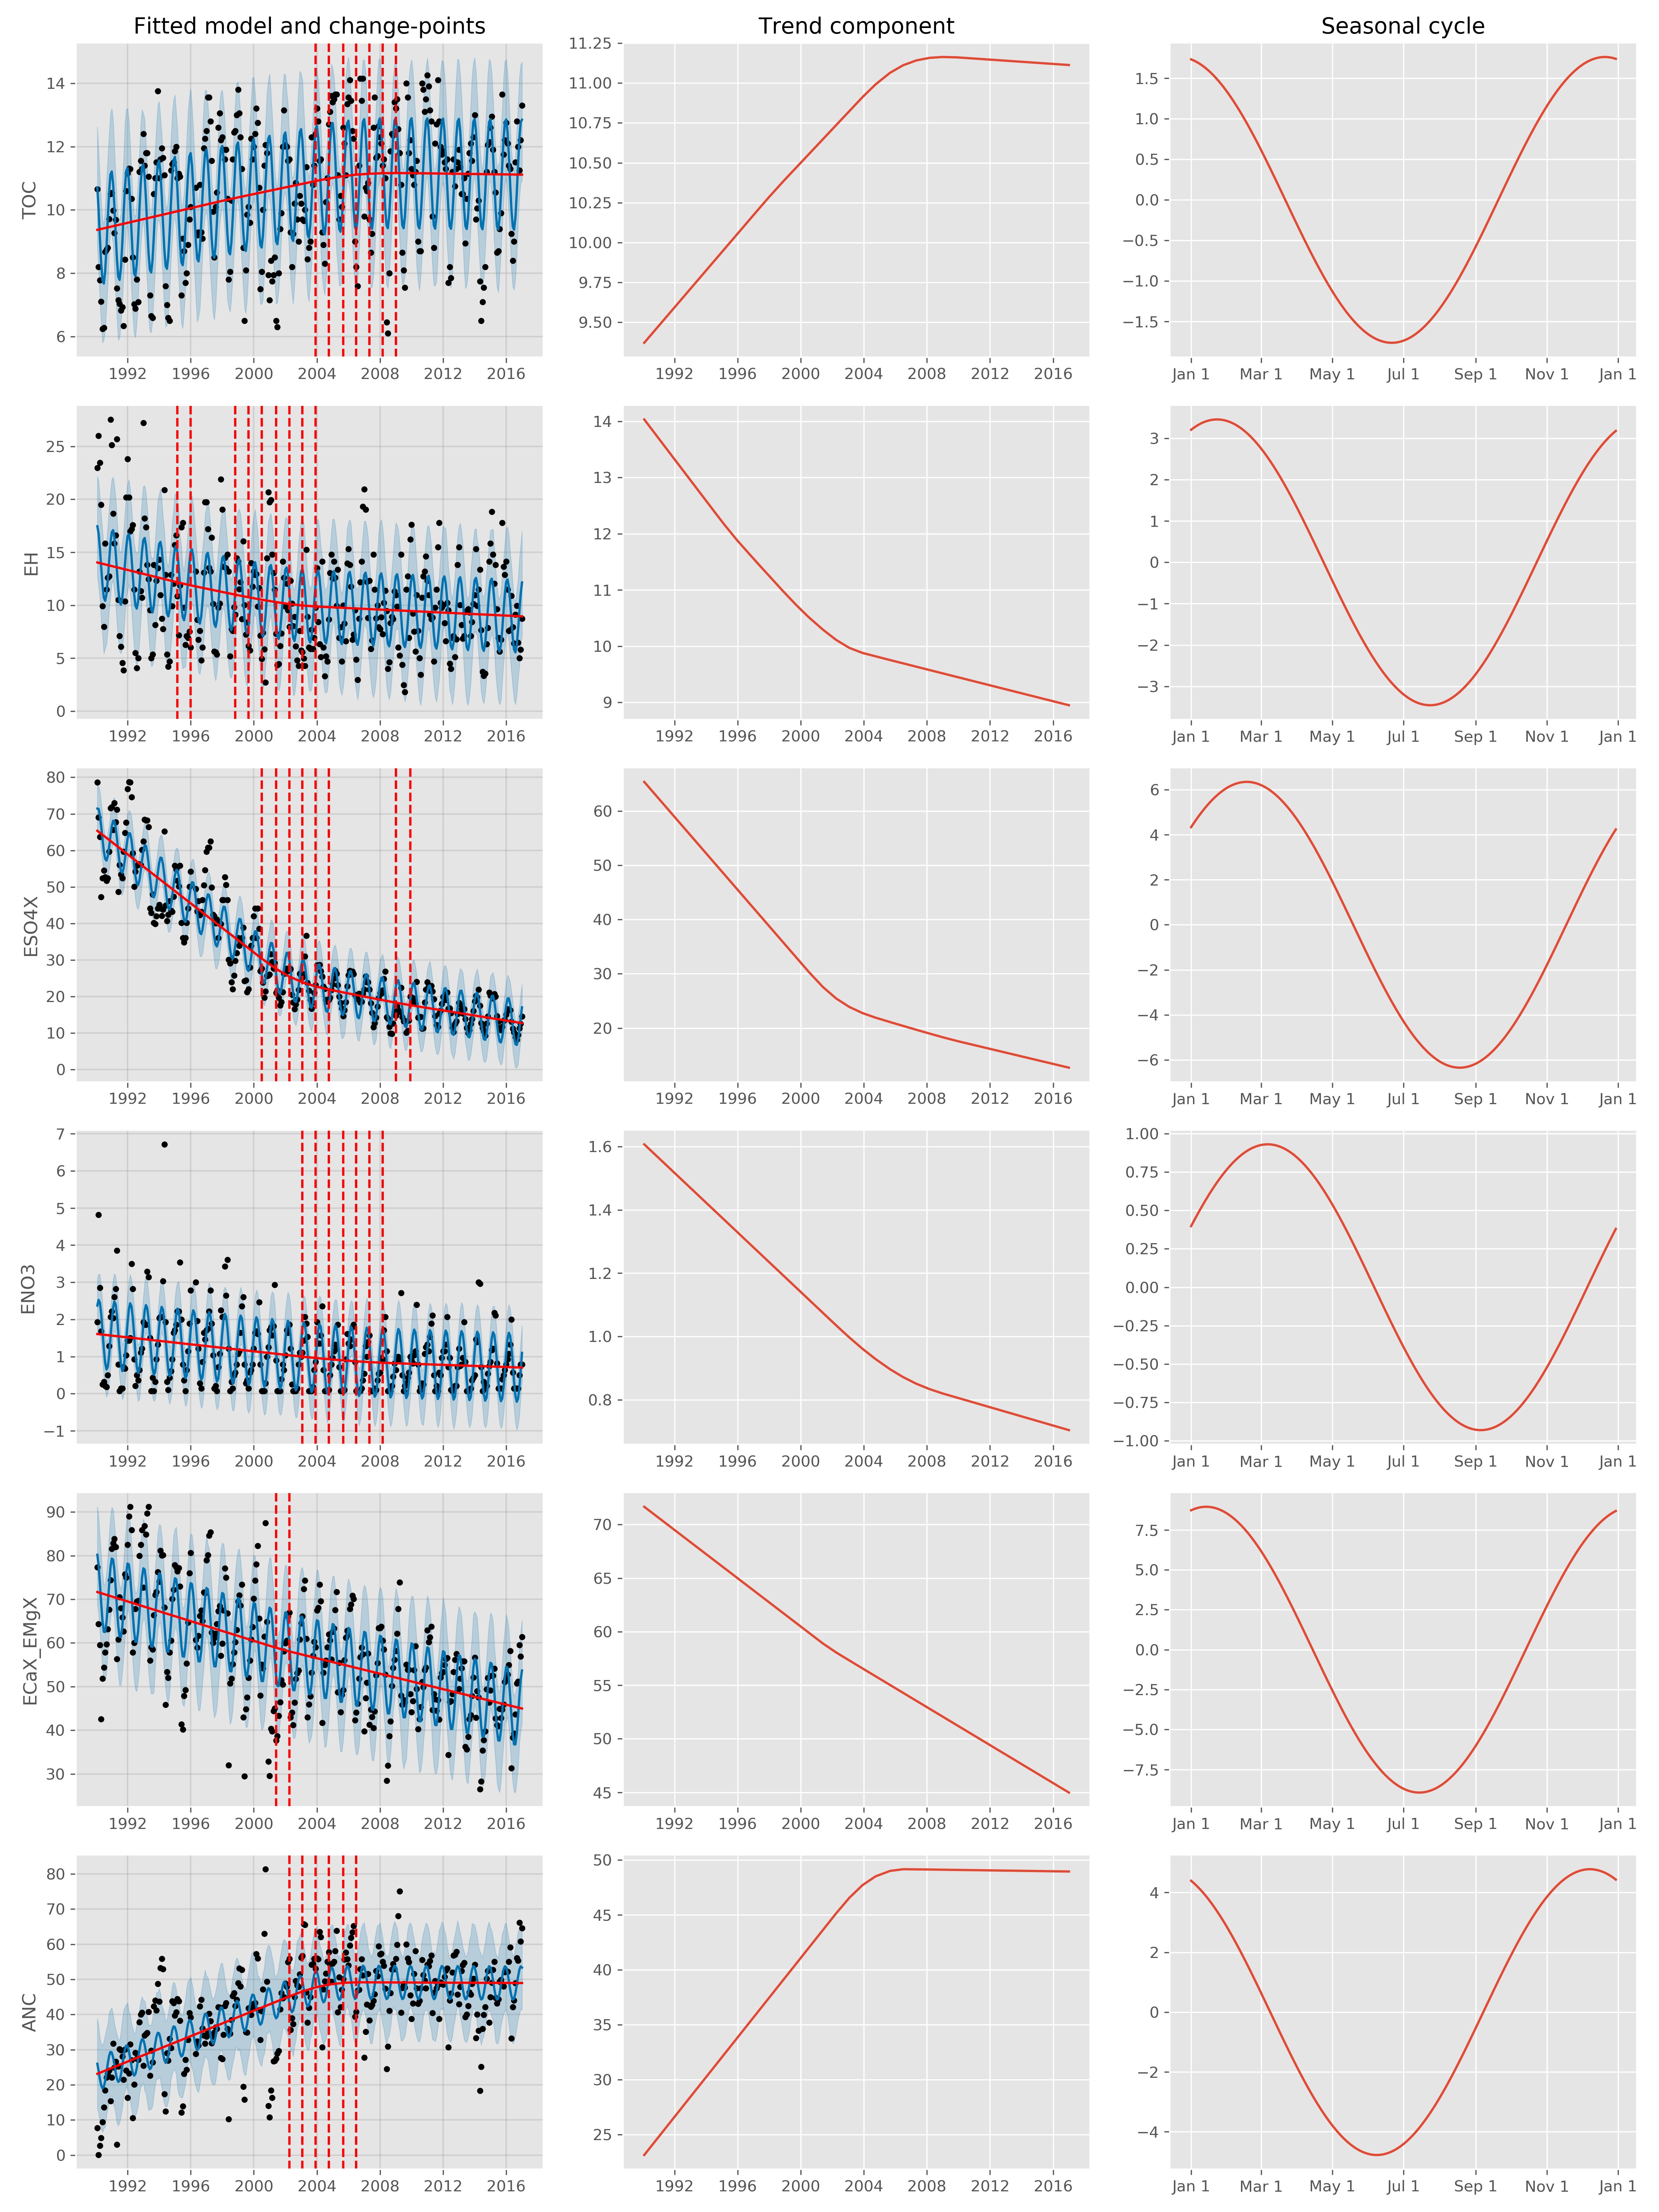

In [6]:
# Show example for Langtjern
Image(r'../../../Thematic_Trends_Report_2019/results/change_plots/prophet_stn_38242.png')

Prophet decomposes the monthly series into a piecewise-linear long-term trends and seasonal components. Taking TOC as an example (first row of plots), the seasonal component suggests that concentrations during the mid-winter are around 1.5 mg-C/l higher than the annual average, while concentrations during mid-summer are roughly 1.5 mg-C/l lower. This seems reasonable, but as a quick sense check the code below produces boxplots showing the distribution of TOC concentrations within each month over the entire data period.

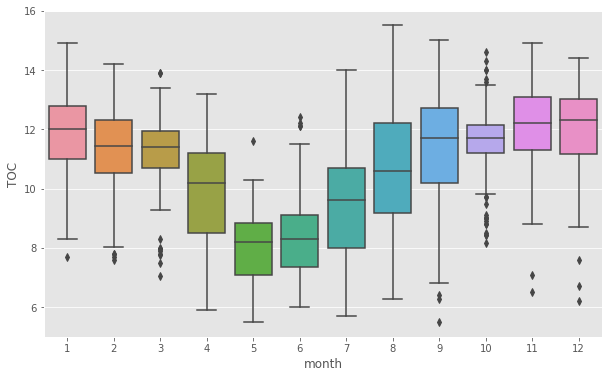

In [7]:
# Boxplots of TOC concentration by month
df = wc_df.query('station_id == 38242').copy()
df['month'] = df['sample_date'].dt.month
fig, ax = plt.subplots(figsize=(10, 6))
sn.boxplot(x='month', 
           y='TOC', 
           data=df, 
           ax=ax)

The boxplot medians show a similar pattern to the Prophet seasonal component for TOC, which is a good sign.

Note that while some of the Prophet models look OK, several of them are not great: the fit for ANC, in particular, seems to substantially underestimate the variance in the observed data.

Overall, there seems to be weak but consistent evidence for changes taking place around or shortly after the year 2000. ESO4X and EH both decline quite rapidly until about 2002, after which they start to level-off. A few years later, around 2004, ANC stops increasing and starts to level off too, and then around 2007 there is evidence for break-points in the curves for TOC and ENO3 (although the magnitude of the change for ENO3 is quite small/subtle compared to the other variables).

The seasonal components are also interesting and seem broadly plausible to me. The TOC cycle is presumably driven by increased uptake and UV breakdown of organic matter during the summer. There is also evidence from the other plots (especially ENO3) of what I assume is a spring "flushing" event (i.e. high concentrations), followed by meltwater dilution.

## 3. BCP package in R

What about stations where we don't have enough data to adequately estimate a seasonal component? The R package [BCP](https://cran.r-project.org/web/packages/bcp/index.html) has an implementation of 
the algorithm of [Barry & Hartigan (1993)](https://www.jstor.org/stable/2290726?seq=1#page_scan_tab_contents), which is flexible and highly regarded within the statistical community. I can't find an implementation of this in Python, but it's not too difficult to link Python and R, which is what I've done below.
   
The code below first calculates annual medians for each site and then transfers the data from Python to R for the change-point analysis. Results are then passed back to Python and displayed in a plot matrix, where each row corresponds to a water chemistry parameter and the columns show (i) the raw data overlaid with the fitted model, and (ii) the posterior probability for a change taking place in each year. I have added dotted horizontal lines to the probability plots at 50% (more likely than not) and 95% (the typical threshold for "statistical significance"). Note, however, that the limited data available (27 data points for the years 1990 to 2016) is rarely sufficient to identify changes with >95% credibility.

Note also that both Prophet and BCP adopt a Bayesian definition of probability, where values express **subjective degrees of belief**, rather than long-run probabilities over many repeated trials, which is the Frequentist interpretation. 

There are two main options to consider when using BCP. For convenience, I've defined the function `'plot_bcp_change_pts'` below, which make it easy to explore the different options, which are as follows: 

  1. **`'reg'` parameter**. Specifies whether each partition of the series is assumed to have constant mean and variance, or whether a linear model is fitted (with `'YEAR'` as the x-variable)
  
  2. **`'p0'` parameter**. Specifies the prior probability of a change taking place at each time point in the series. Smaller values mean fewer change-points will be identified
  
Heleen has previously referenced [Espen's recent paper](https://link.springer.com/article/10.1007%2Fs11270-018-4013-9), which made use of a software package called [Change-Point Analyzer](https://variation.com/product/change-point-analyzer/). I can't find much detail concerning the method used by this program, but the plots in Espen's paper suggest the algorithm partitions time series into block where the means are assumed to be *constant*. This would correspond to using `'reg=False'` in my function below, whereas e.g. Prophet fits piecewise linear trendlines, which would correspond to `'reg=True'`.

In [8]:
def listvector_to_dict(lv):
    """ Convert R ListVector to a Python dict.
    """
    return dict(zip(lv.names, map(list,list(lv))))

def plot_bcp_change_pts(stn_id, reg=True, p0=0.2):
    """ Run BCP analysis to detect change-points.
    """
    # Get data for stn
    df = wc_df.query('station_id == @stn_id').copy()
    del df['station_id'], df['station_code'], df['station_name']
    del df['depth1'], df['depth2']
    
    df.set_index('sample_date', inplace=True)
    df = df.resample('A').median().reset_index()
    df['year'] = df['sample_date'].dt.year
    del df['sample_date']

    # Interpolate years with missing data
    index_df = pd.DataFrame({'year':range(1990, 2017)})
    df = pd.merge(index_df, df, how='left', on='year')
    df.interpolate(kind='linear', inplace=True)

    # Setup plot
    fig, axes = plt.subplots(nrows=6, ncols=2, 
                             sharex=False,
                             sharey=False,
                             figsize=(15,15))

    # Loop over data
    for idx, par in enumerate(pars):
        # Change point analysis
        if reg:
            # Perform regression within each partition
            res = bcp.bcp(df[par], 
                          x=df['year'], 
                          p0=p0)
        else:
            # Assume constant mean within each partition
            res = bcp.bcp(df[par], 
                          p0=p0)            
            
        res = listvector_to_dict(res)

        res = pd.DataFrame({'raw':df[par].values,
                            'mean':res['posterior.mean'],
                            'prob':res['posterior.prob']},
                           index=df['year'].values)

        # Plot
        res['raw'].plot(ax=axes[idx, 0], marker='o', linestyle=':', label='Raw')
        res['mean'].plot(ax=axes[idx, 0], label='Fitted')
        axes[idx, 0].set_ylabel(par)
        axes[idx, 0].legend(loc='best')

        res['prob'].plot(ax=axes[idx, 1], marker='o')
        axes[idx, 1].set_ylabel('Probability')
        axes[idx, 1].set_ylim((0, 1))
        axes[idx, 1].axhline(0.5, c='k', linestyle='--')
        axes[idx, 1].axhline(0.95, c='k', linestyle='--')

    axes[0, 0].set_title('Data series')    
    axes[0, 1].set_title('Change probability')
    plt.tight_layout()
    out_png = os.path.join(out_fold, 'bcp_stn_%s.png' % stn_id)
    plt.savefig(out_png, dpi=300)
    plt.close()

### 3.1. Default options

Piecewise linear regression and a prior change probability of 0.2.

In [9]:
# Deafult options
for stn_id in hi_freq_df['station_id'].values:
    plot_bcp_change_pts(stn_id)

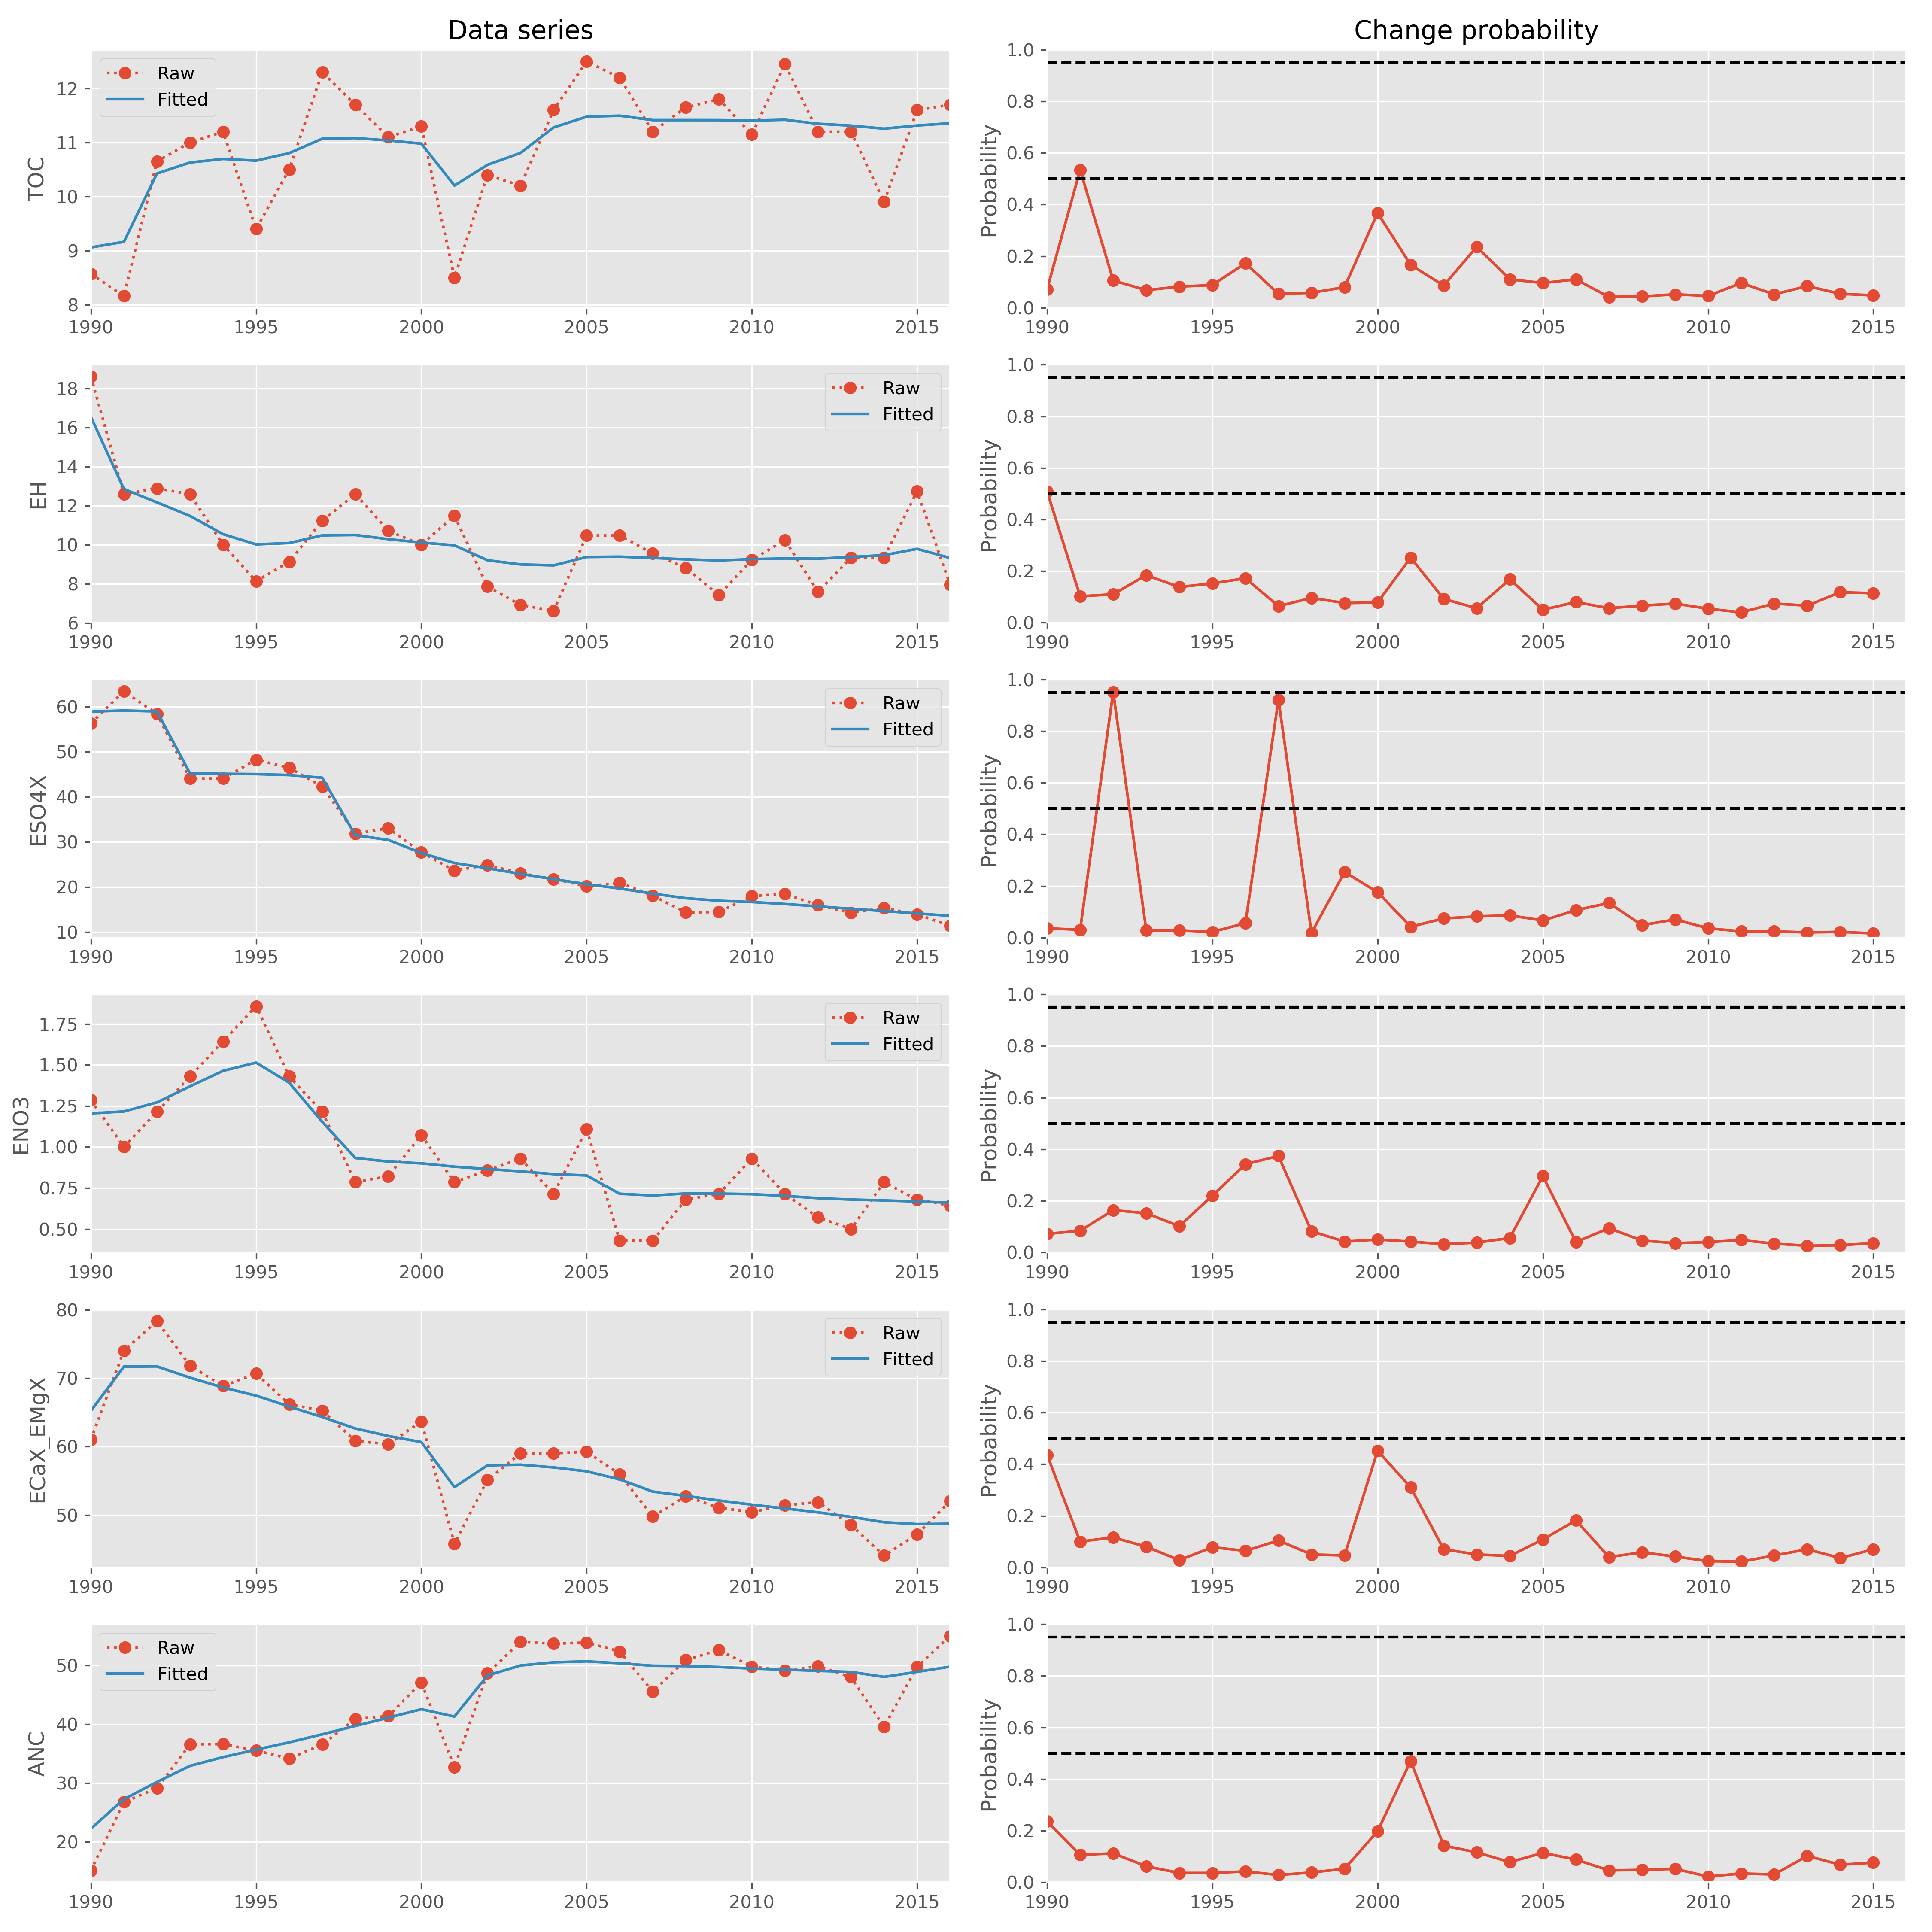

In [10]:
Image(r'../../../Thematic_Trends_Report_2019/results/change_plots/bcp_stn_38242.png')

It is interesting to note the differences with Prophet here: the plot for TOC, for example, does not show any significant change-points - certainly not during the period between 2005 and 2010. The explanation appears to be that BCP is fitting many more break-points to the piecewise regression, whereas Prophet takes a more parsimonious approach and essentially fits just two linear trend segments with a single break-point in the period 2005 - 2008. Both models look quite reasonable to my eye: if I had to draw a smooth curve through the aggregated annual TOC dataset, it would look quite similar to the trendline identified by Prophet. However, the less smooth line fitted by BCP is also a plausible approximation.

### 3.2. Reduced change probability; no regression

What about reducing the prior change probability to reduce the number of possible change-points, and turning off regression to be more comparable with Espen's approach?

In [14]:
%%capture
# Reduced p0
for stn_id in hi_freq_df['station_id'].values:
    plot_bcp_change_pts(stn_id, reg=False, p0=0.1)

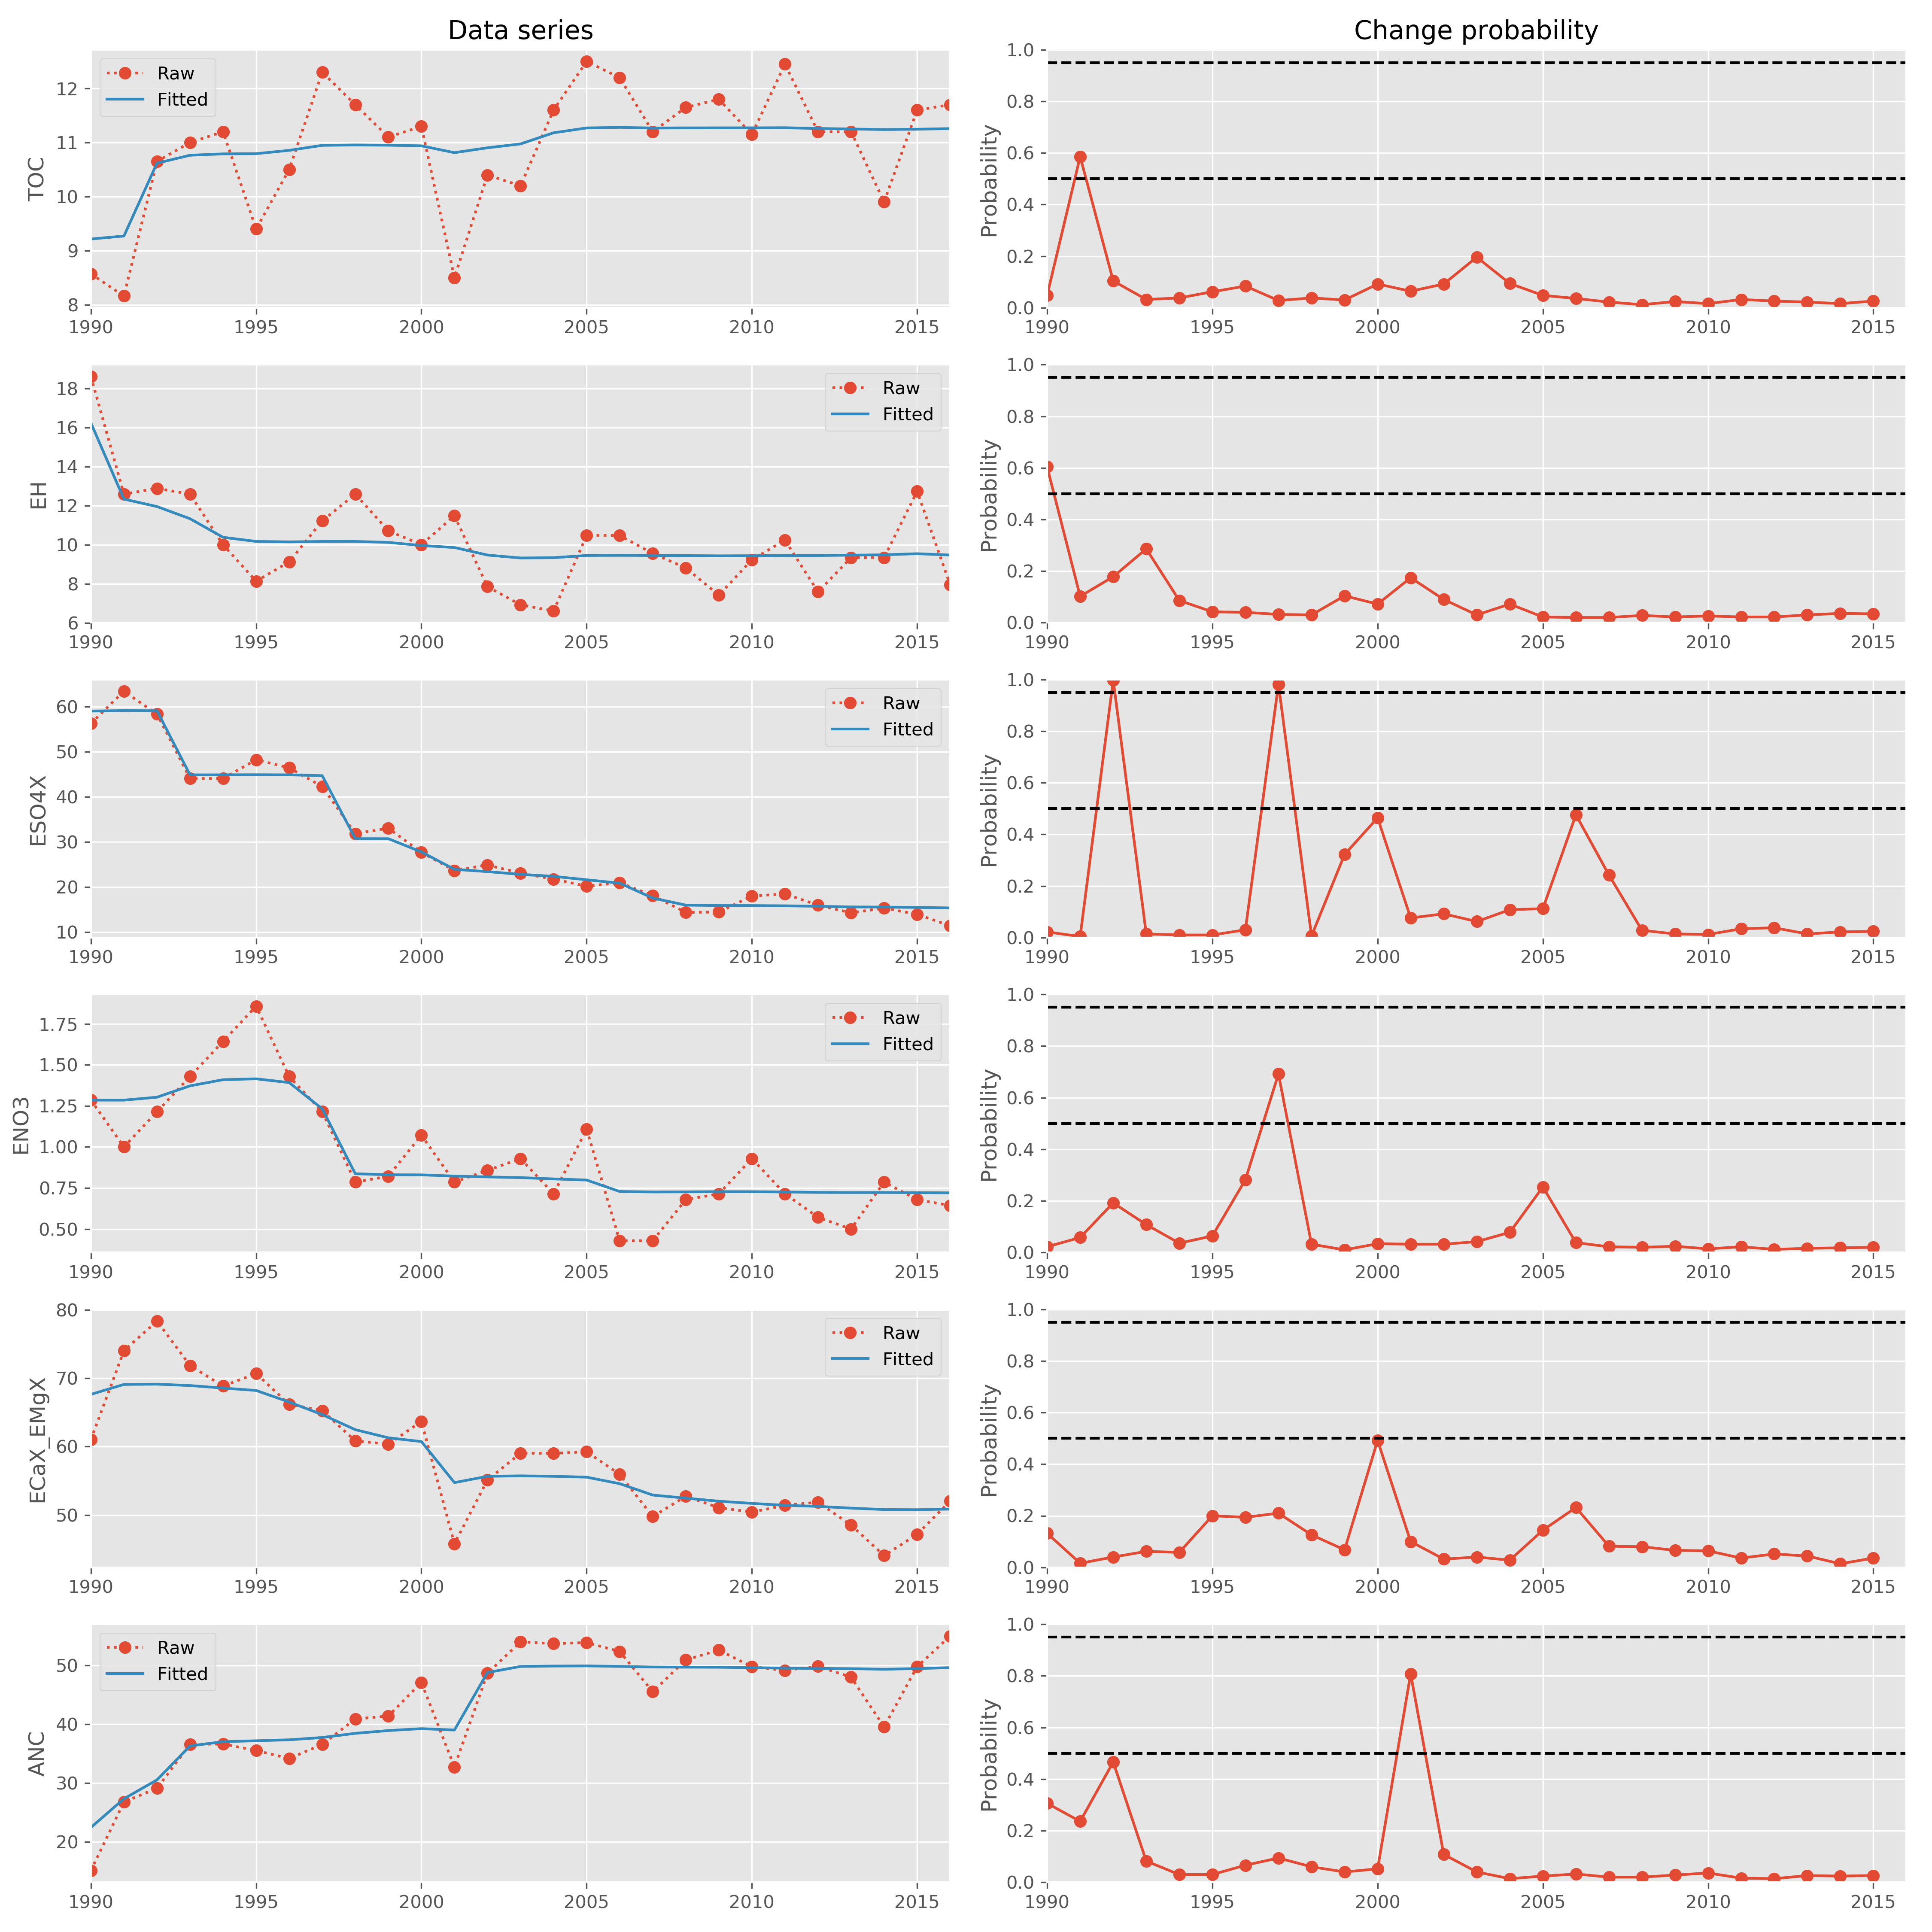

In [15]:
Image(r'../../../Thematic_Trends_Report_2019/results/change_plots/bcp_stn_38242.png')

These results seem quite sensible. Fewer change-points are identified, but those that are picked-out seem quite clear to me. Comparing the plots for ESO4X and ANC to Espen's *Fig. 2*, the results are quite similar. Overall I think this approach provides a reasonable Bayesian alternative to the package used by Espen for his paper.

## 4. Patterns by country

### 4.1. USA

The two US sites with high frequency data are **river** stations, one in the Catskills and one in Virginia.
 
 * Long-term trends are fairly steady in Virginia - the break-points identified usually represent minor changes in slopes. Trends are more pronounced in the Catskills. In both locations, nitrate seems to decline rapidly and then level-off, but the raw data during the early 1990s look suspiciously high, so I wonder if this is a data quality issue?
 
 * The BCP analysis does not identify any change points in Virginia. Some step-changes are identified for the Catskills, but they are not easy to interpret. 
 
### 4.2. Canada

The four Canadian sites with the most data are all **lakes** in the Algoma region of Ontario.

 * The seasonal cycles for each variable are broadly the same across the four sites: TOC, ECaX_EMgX and ANC are all at their lowest during spring (April - May) and peak in the autumn (October-ish); EH and nitrate are at their highest in spring and lowest by autumn; ESO4X peaks in February and reaches a minimum around August
 
 * The series for nitrate and EH are fairly steady, with no obvious trends or break-points. The TOC series are also fairly constant, with only weak (not significant) suggestions of increasing concentrations over time
 
 * The series for ESO4X, ECaX_EMgX and ANC are all consistent and distinctive. ESO4X declined quickly between 1990 and 1995/6, then remained steady until 2005, before starting to decline rapidly again. The same general patterns are apparent for ECaX_EMgX and ANC, except there's a slight lag in the break-points (i.e. the changes didn't take place until 1998 and 2010-ish). In addition, between 1998 and 2010, ECaX_EMgX and ANC actually increased slightly, instead of levelling-off like ESO4X 
 
 * The BCP analysis identifies some consistent step changes: TOC in 1997; ESO4X in 1993, 2007 and 2013; ENO3 in 1995, 2007 and 2009; and ANC in 2005
  
### 4.3. Norway

Of the five Norwegian sites, two are **lake** outflows (LAE01 and KAE01) and the rest are **rivers**. The Norwegian dataset is more variable than the data from North America, perhaps because the Norwegian sites cover a broader range of climate?

 * The seasonal cycles for each parameter vary considerably from site to site
 
 * Trends in TOC are positive and mostly steady, except at Langtjern, where there is weak evidence for levelling-off since 2007
 
 * EH is declining. At LAE01, BIE01 and STE01 there is evidence for a break-point around 2002, with more rapid decline prior to this and levelling-off since. At the other two sites, the declining trend is roughly constant through time
 
 * The pattern for ESO4X is similar: LAE01, BIE01 and STE01 show a fairly rapid decline before 2002 and a levelling-off since. Interestingly, at KAE01 and DALELV, the ESO4X record has a similar shape, but with the obvious break-point in 2006/7 instead of 2002 i.e. whatever caused the change took longer to affect these sites
 
 * The nitrate record is noisy but with a suggestion of weak declining trends. At LAE01 and STE01 there is a vague suggestion of a break-point in around 2006, but nothing very convincing
 
 * ANC has increased across all sites and there appears to be a break-point between around 2003-5 (increases were more rapid before this date, and have levelled-off slightly since)
 
 * The BCP analysis picks out relatively few consitent step changes between sites, but there is evidence for a change in ESO4X at sites LAE01, BIE01 and STE01 taking place around 1996-8 

## 5. Summary

 * Both BCP and Prophet pick out interesting patterns, but they do not necessarily focus on the same features. In general, I'd say BCP does a pretty good job of picking out step-changes, whereas Prophet focuses more on long-term trends. For sites with lots of data, I think it's interesting to apply both methods, and for those with more limited data just applying BCP is still worthwhile. However, it seems clear that BCP *will not* identify the same features picked out by Prophet using just the aggregated annual data
 
 * Some of the Prophet models are poor and will require further tuning/investigation. In addition, some of the aggregated monthly values look dubious, so we will probably need to do more data cleaning before going much further. One advantage of aggregating everything by taking annual medians is that the influence of anomalous results is substantially reduced
 
 * There are significant upward trends in TOC at the five Norwegian sites. These trends are steady over time (only at Langtjern is there *weak* evidence of TOC concentrations levelling-off). In contrast, trends in TOC are **not** significant at any of the North American sites considered here
 
 * There are significant decreasing trends in ESO4X everywhere. In Norway, concentrations initially declined rapidly, before levelling-off in recent years. At LAE01, BIE01 and STE01, the break-point in the sulphate record takes place around 2002; for KAE01 and DALELV it happens around 2006/7. In the USA, sulphate declines steadily over time, with little evidience for any changes in slopes. In the Algoma region of Canada, meanwhile, sulphate declines rapidly until 1995/6, then remains steady until 2005, before decling rapidly once more
 
 * All of the Norwegian sites except BIE01 show significant decreasing trends in nitrate. In general these trends are steady, with no obvious break-points. In North America, only one of the six sites (CA01) has a decreasing nitrate trend; all the rest are non-significant. There are obvious break-points in the nitrate series from the USA, but I suspect these may be due to data quality issues